## Gaussian decomposable graphical model

Fitting multiple Gaussian decomposable graphical model to simulated G from auto-regressive process

In [2]:
SAVE_PLOTS = False
SAVE_IMG_LOC =  '~/src/'
SAVE_LOC = '~/src/'

In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

import time
from parallelDG.graph import trajectory
import parallelDG.graph.graph as glib
import parallelDG.graph.decomposable as dlib
import parallelDG.distributions.g_intra_class as gic
import parallelDG.auxiliary_functions as aux
from parallelDG.distributions import discrete_dec_log_linear as loglin
import parallelDG.mh_parallel as pdg
from networkx.drawing.nx_pydot import graphviz_layout
sns.set_style("whitegrid")
options = {
    "font_size": 8,
    "node_size": 100,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
}
def save_location(filename, loc = SAVE_IMG_LOC):
    if SAVE_PLOTS:
        plt.savefig(loc + filename + '.png', dpi = 600, bbox_inches='tight')
    else: 
        plt.show()

### Simulating AR(1-5) Gaussian graphical model

In [6]:
p = 50
sigma2 = 1.0
rho = 0.9
n = 100
delta = 5

Number of edges 85, number of nodes 50
loglikelihood 1592.785678


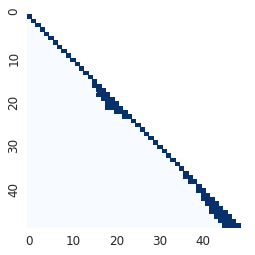

In [4]:
np.random.seed(2) # generates same data as in the paper
ar_graph = dlib.sample_random_AR_graph(n_dim=p, max_bandwidth=delta)
aux.plot_heatmap(nx.to_numpy_array(ar_graph), xticklabels=10, yticklabels=10)
ar_cov_mat = gic.cov_matrix(ar_graph, rho, sigma2)
ar_df = pd.DataFrame(np.random.multivariate_normal(np.zeros(p), ar_cov_mat, n))
print('Number of edges {}, number of nodes {}'.format(ar_graph.size(), ar_graph.order()))
print('loglikelihood {:2f}'.format(pdg.ggm_loglikelihood(dataframe=ar_df,
                                                         graph=ar_graph,
                                                         graph_prior=['uniform'], 
                                                         delta=delta)))
#save_location('ggm_true_graph_adj')

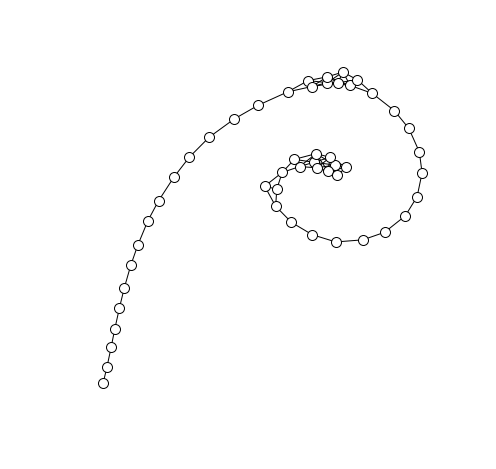

In [5]:
# Graph
plt.figure(figsize=(8,8))
pos = graphviz_layout(ar_graph, prog="fdp",)
nx.draw_networkx(ar_graph,pos=pos, with_labels=False, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
save_location('ggm_true_graph')

In [7]:
n_samples = 500000
randomize  = 100
graph_prior = ['uniform', 2.0, 4.0]
delta = 5.0
burnin = 200000
seed = 0# 12345

##  Multiple runs

In [8]:
randomize  = 100
graph_prior = ['uniform', 2.0, 4.0]
delta = 5.0
burnin = 200000
def multiple_runs(seed, single_move = False):
    import json
    if single_move:
        n_samples = 1000000
        traj = pdg.sample_trajectory_ggm(dataframe=ar_df, 
                                 n_samples=n_samples,
                                 randomize=randomize, 
                                 graph_prior = graph_prior,
                                 delta = delta, 
                                 seed = seed,
                                 single_move = True)
        
    else:
        n_samples = 500000
        traj = pdg.sample_trajectory_ggm(dataframe=ar_df, 
                                     n_samples=n_samples,
                                     randomize=randomize, 
                                     graph_prior = graph_prior,
                                     delta = delta, 
                                     seed = seed)
    traj.graph_updates = None
    traj.set_graph_trajectories(index_type = 'mcmc_index')
    acc_mcmc_index = aux.acceptance_ratio(traj.trajectory)
    traj.graph_updates = None
    traj.set_graph_trajectories(index_type = 'mcmc_subindex')
    acc_mcmc_subindex = aux.acceptance_ratio(traj.trajectory)
        ## of the juncion tree
    up = [0] * traj.n_updates
    for x in traj.jt_updates: 
        up[x[1]-1] = 1
        
    traj._size=None
    traj.graph_updates = None
    traj.set_graph_trajectories(index_type = 'mcmc_index')
    traj.size().plot(color = 'black')
    size_mcmc_index = list(traj._size)
    
    traj._size=None
    traj.graph_updates = None
    traj.set_graph_trajectories(index_type = 'mcmc_subindex')
    traj.size().plot(color = 'black')
    size_mcmc_subindex = list(traj._size)

    burnin = 50000
    lag=20000
    df = pd.DataFrame({'mcmc_index': size_mcmc_index[-burnin:],
                   'mcmc_subindex': size_mcmc_subindex[-burnin:]})
    y_index = aux.autocorrelation_plot(df['mcmc_index'], label = 'MCMC index', 
                                 color = 'black', 
                                 lag =lag, 
                                 return_series=True)
    y_subindex = aux.autocorrelation_plot(df['mcmc_subindex'], 
                                              label = ' MCMC subindex',
                                              color = 'black',
                                              ls = ':', lag = lag,
                                              return_series=True)
        ## SAVE JSON
    data = {
            "autocorr_index" : y_index, 
            "autocorr_subindex": y_subindex, 
            "lag" : lag, 
            "burnin_last": burnin, 
            "size_mcmc_index" : size_mcmc_index, 
            "size_mcmc_subindex" :size_mcmc_subindex, 
            "acc_mcmc_index" : list(acc_mcmc_index[1]), 
            "acc_avg_index" : acc_mcmc_index[0],
            "acc_mcmc_subindex": list(acc_mcmc_subindex[1]), 
            "acc_avg_subindex" : acc_mcmc_subindex[0],
            "acc_mcmc_junction" : up, 
            "logl" : traj.logl,
        }
    if single_move: 
        filename = SAVE_LOC + str(seed) + 'single_move.json'
    else:
        filename = SAVE_LOC + str(seed) + '.json'
    with open(filename, 'w') as outfile:
        json.dump(data, outfile)
    print('saved file:' + SAVE_LOC)

In [ ]:
### Plotting multple autocorrelation plots
import json
def read_file(filename):
    """ Reads a trajectory from json-file.
    """
    with open(filename) as mcmc_file:
        mcmc_json = json.load(mcmc_file)
    return mcmc_json
    
def get_variable(variable, extra_name = ''):
    seeds = list(range(10))
    data = dict()
    for s in seeds: 
        filename = SAVE_LOC + str(s) + extra_name + '.json'
        d = read_file(filename)
        data[s] = d[variable]
    return data

# Start of run

In [15]:
seeds = [0,1,2,3,4,5,6,7,8,9]
# multi-move
for s in seeds: 
    multiple_runs(s)
# single-move
for s in seeds: 
    multiple_runs(s, True)
#multiple_runs(seeds)

Parallel Metropolis-Hastings samples:   2%|▏         | 8036/499999 [00:03<03:25, 2388.95it/s]


KeyboardInterrupt: 

In [8]:
data = get_variable('autocorr_index')
x = np.arange(len(data[0])) + 1
datasub = get_variable('autocorr_subindex')

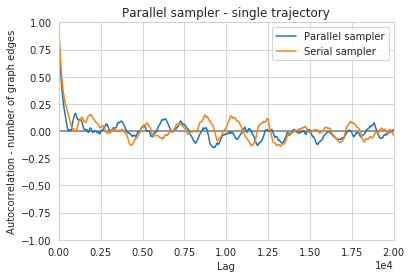

In [9]:
ax = plt.gca(xlim=(1, np.max(x)), ylim=(-1.0, 1.0))
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation - number of graph edges")
i = 5
ax.plot(x, data[i], label = 'Parallel sampler')
ax.plot(x, datasub[i], label = 'Serial sampler')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Parallel sampler - single trajectory')
plt.legend()
save_location('ggm_traj_autocorrelation_index_sub')

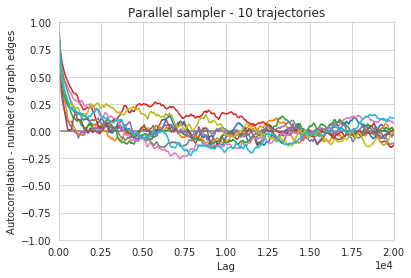

In [11]:
data = get_variable('autocorr_index')
x = np.arange(len(data[0])) + 1
ax = plt.gca(xlim=(1, np.max(x)), ylim=(-1.0, 1.0))
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation - number of graph edges")
for key, y in data.items(): 
    ax.plot(x, y)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Parallel sampler - 10 trajectories')
save_location('ggm_10_traj_autocorrelation')

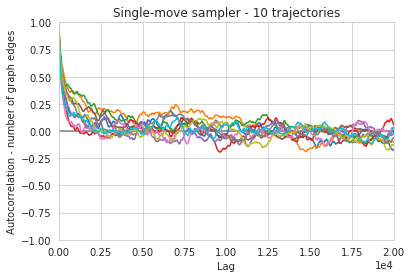

In [12]:
data = get_variable('autocorr_index', 'single_move')
x = np.arange(len(data[0])) + 1
ax = plt.gca(xlim=(1, np.max(x)), ylim=(-1.0, 1.0))
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation - number of graph edges")
#ax.set_ylabel("Autocorrelation")
for key, y in data.items(): 
    ax.plot(x, y)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Single-move sampler - 10 trajectories')
save_location('ggm_10_traj_autocorrelation_single_move')    

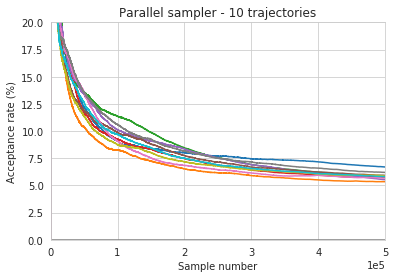

In [10]:
data = get_variable('acc_mcmc_index')
x = np.arange(len(data[0])) + 1
ax = plt.gca(xlim=(1, np.max(x)), ylim=(0, 20))
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Sample number")
ax.set_ylabel("Acceptance rate (%)")
for key, y in data.items(): 
    ax.plot(x, np.array(y) * 100.0)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Parallel sampler - 10 trajectories')
save_location('ggm_10_traj_acceptance_ratio')

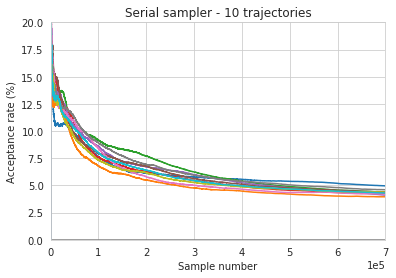

In [11]:
data = get_variable('acc_mcmc_subindex')
max_x = 700000
x = np.arange(max_x) + 1
ax = plt.gca(xlim=(1, max_x), ylim=(0, 20))
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Sample number")
ax.set_ylabel("Acceptance rate (%)")
for key, y in data.items(): 
    ax.plot(x, np.array(y[:max_x])* 100.0)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Serial sampler - 10 trajectories')
save_location('ggm_10_traj_acceptance_ratio_subindex')

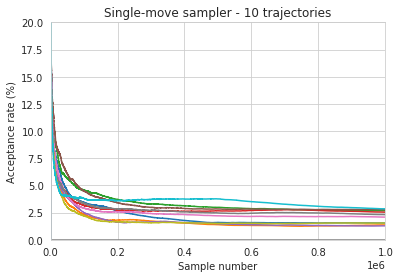

In [12]:
data = get_variable('acc_mcmc_index', 'single_move')
x = np.arange(len(data[0])) + 1
ax = plt.gca(xlim=(1, np.max(x)), ylim=(0, 20))
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Sample number")
ax.set_ylabel("Acceptance rate (%)")
for key, y in data.items(): 
    ax.plot(x, np.array(y) * 100.0)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Single-move sampler - 10 trajectories')
save_location('ggm_10_traj_acceptance_ratio_single_move')

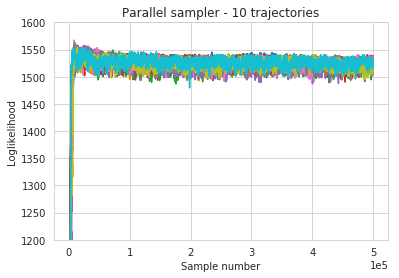

In [16]:
data = get_variable('logl')
burnin = 0
for key, y in data.items():
    yy = y[-burnin:]
    x = list(range(len(yy)))
    plt.plot(x, yy)

plt.xlabel('Sample number')
plt.ylabel('Loglikelihood')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylim((1200,1600))
plt.title('Parallel sampler - 10 trajectories')
save_location('ggm_10_traj_loglikelihood_traceplot')

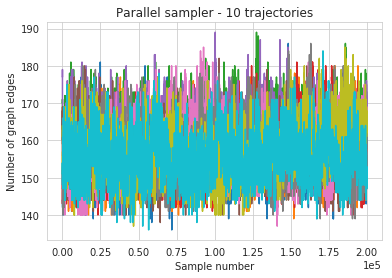

In [17]:
data = get_variable('size_mcmc_index')
burnin = 200000
x = list(range(burnin))
for key, y in data.items():
    plt.plot(x, y[-burnin:])

plt.xlabel('Sample number')
plt.ylabel('Number of graph edges')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Parallel sampler - 10 trajectories')
save_location('ggm_10_traj_size_traceplot')

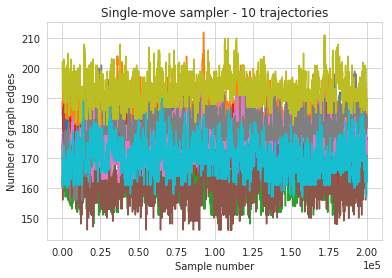

In [18]:
data = get_variable('size_mcmc_index', 'single_move')
burnin = 200000
x = list(range(burnin))
for key, y in data.items():
    plt.plot(x, y[-burnin:])

plt.xlabel('Sample number')
plt.ylabel('Number of graph edges')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Single-move sampler - 10 trajectories')
save_location('ggm_10_traj_size_traceplot_single_move')

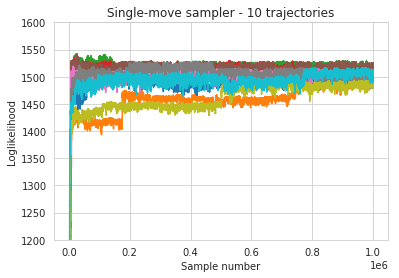

In [6]:
data = get_variable('logl', 'single_move')
burnin = 0
for key, y in data.items():
    yy = y[-burnin:]
    x = list(range(len(yy)))
    plt.plot(x, yy)

plt.xlabel('Sample number')
plt.ylabel('Loglikelihood')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylim((1200,1600))
plt.title('Single-move sampler - 10 trajectories')
save_location('ggm_10_traj_loglikelihood_traceplot_single_move')

In [20]:
data = get_variable('acc_mcmc_index')
datasub = get_variable('acc_mcmc_subindex')
x = np.arange(len(datasub[0])) + 1
datasingle = get_variable('acc_mcmc_index', 'single_move')

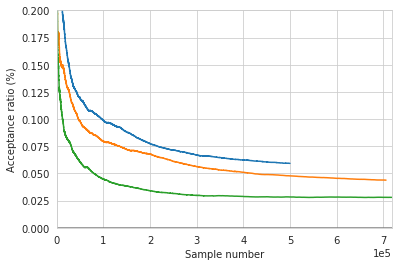

In [21]:
i = 5#1,8,5
max_x = np.max(x)
ax = plt.gca(xlim=(1, max_x), ylim=(0, 0.2))
y = data[i]
z = datasub[i]
f = datasingle[i]
ax.plot(list(range(len(y))), y, label = 'MCMC index')
ax.plot(list(range(len(z))), z, label = 'MCMC subindex')
ax.plot(list(range(len(f))), f, label = 'single-move')
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Sample number")
ax.set_ylabel("Acceptance rate (%)")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
#plt.title('Parallel sampler - MCMC subindex - 10 trajectories')
#save_location('ggm_10_traj_acceptance_ratio_subindex')